# InSituPy demonstration - InSituExperiment
## Background

<div style="display: flex; align-items: center;">
    <img src="./demo_screenshots/experiment_levels.png" height=300 alt="Description" style="margin-right: 10px;">
    <p>Beside the sample, cellular and subcellular level, a spatial transcriptomics dataset usually consists also of an experiment level including information about clinical and experimental cohorts, conditions or treatments. Most current computational frameworks do not provide functionalities to include this level into the analysis. For this purpose `InSituPy` introduces the `InSituExperiment` class which handles spatial transcriptomics data and the corresponding metadata of multiple samples in parallel.</p>
</div>

## Structure

<img src="./demo_screenshots/insituexperiment_structure.png" height=200 alt="Description" style="margin-right: 10px;">

In [1]:
## The following code ensures that all functions and init files are reloaded before executions.
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from insitupy import InSituData
from insitupy import InSituExperiment

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Load Xenium data into `InSituData` object

Now the Xenium data can be parsed by providing the data path to the `InSituPy` project folder.

In [4]:
insitupy_project = Path("demo_dataset/demo_insitupy_project")
xd = InSituData.read(insitupy_project)
xd.load_all(skip="transcripts")
xd

InSituData
Method:		Xenium
Slide ID:	0001879
Sample ID:	Replicate 1
Path:		C:\Users\ge37voy\Github\InSituPy\notebooks\demo_dataset\demo_insitupy_project
Metadata file:	.ispy
    ➤ images
       nuclei:	(25778, 35416)
       CD20:	(25778, 35416)
       HER2:	(25778, 35416)
       DAPI:	(25778, 35416)
       HE:	(25778, 35416, 3)
    ➤ cells
       matrix
           AnnData object with n_obs × n_vars = 163565 × 313
           obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes', 'leiden', 'cell_type_dc', 'cell_type_tacco'
           var: 'gene_ids', 'feature_types', 'genome'
           uns: 'cell_type_colors', 'cell_type_dc_colors', 'cell_type_tacco_colors', 'counts_location', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
           obsm: 'OT', 'X_pca', 'X_umap', 'annotations', 'ora_estimate', 'ora_pvals', 'regions', 'spatial'
           varm: 'OT', 'PCs', 'binned_expression'
           layers

### Create `InSituExperiment`

<left><img src="./demo_screenshots/insituexperiment_generation.png" height="250"/></left>

*Options to generate an InSituExperiment object*

#### Method 1: Manually add `InSituData` objects

In [5]:
exp = InSituExperiment()
exp.add(
    data=xd,
    metadata={
        "slide_id": xd.slide_id,
        "sample_id": xd.sample_id,
        "patient": "A"
    }
    )

In [6]:
exp

InSituExperiment with 1 samples:
           uid slide_id    sample_id patient
0     b6126d40  0001879  Replicate 1       A

In the same way also other datasets can be added. For demonstration purposes, we just add the same dataset again and change the metadata.

In [7]:
exp.add(
    data=xd,
    metadata={
        "slide_id": xd.slide_id,
        "sample_id": xd.sample_id,
        "patient": "A",
        "therapy": "drugB"
    }
    )

In [8]:
exp

InSituExperiment with 2 samples:
           uid slide_id    sample_id patient therapy
0     b6126d40  0001879  Replicate 1       A     NaN
1     e060cda5  0001879  Replicate 1       A   drugB

#### Method 2: From config file

As config file either a csv file or an excel file can be used.

Example of a valid configuration file:

| directory         | experiment_name | date       | patient    |
|-------------------|-----------------|------------|------------|
| /path/to/dataset1 | Experiment 1    | 2023-09-01 | Patient A  |
| /path/to/dataset2 | Experiment 2    | 2023-09-02 | Patient B  |

In [9]:
exp = InSituExperiment.from_config(config_path="./demo_experiment/insituexperiment_config.csv")

In [10]:
exp

InSituExperiment with 2 samples:
           uid slide_id sample_id patient therapy
0     d7a26e21     None      None       A   drugA
1     474094b7     None      None       B   drugB

#### Method 3: From regions

We can also use regions from an `InSituData` object to split the data into separate datasets and create an `InSituExperiment` from them. This can be used to select the most interesting regions and focus on them for the analysis or to split a TMA dataset into separate datasets for each core.

In [11]:
exp = InSituExperiment.from_regions(
    data=xd, region_key="TMA"
)

In [12]:
exp

InSituExperiment with 6 samples:
           uid slide_id    sample_id region_key region_name
0     9e879260  0001879  Replicate 1        TMA         A-1
1     3f7e1220  0001879  Replicate 1        TMA         A-2
2     1daa1a53  0001879  Replicate 1        TMA         A-3
3     dea4b694  0001879  Replicate 1        TMA         B-1
4     12dea2ba  0001879  Replicate 1        TMA         B-2
5     56f28cbb  0001879  Replicate 1        TMA         B-3

In [13]:
# visualize data
viewer = exp.show(2)

## Plot overview of metadata and QC metrics

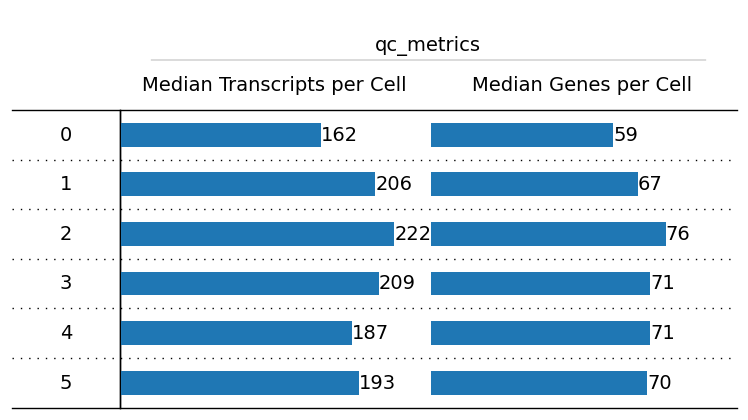

In [14]:
exp.plot_overview()

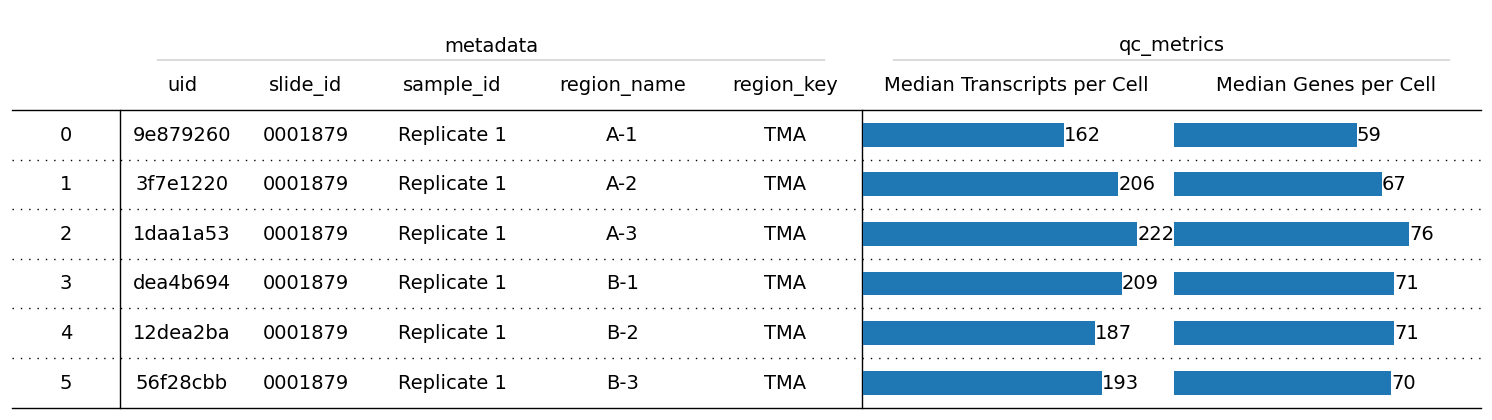

In [15]:
exp.plot_overview(["uid", "slide_id", "sample_id", "region_name", "region_key"], index=True)

## Iterate through `InSituExperiment` using `.iterdata()` method

In [16]:
for metadata, data in exp.iterdata():
    print(f"Metadata:\n{metadata[:3]}\nData:\n{data}")

Metadata:
uid             9e879260
slide_id         0001879
sample_id    Replicate 1
Name: 0, dtype: object
Data:
InSituData
Method:		Xenium
Slide ID:	0001879
Sample ID:	Replicate 1
Path:		C:\Users\ge37voy\Github\InSituPy\notebooks\demo_dataset\demo_insitupy_project
Metadata file:	.ispy
    ➤ images
       nuclei:	(4706, 4706)
       CD20:	(4706, 4706)
       HER2:	(4706, 4706)
       DAPI:	(4706, 4706)
       HE:	(4706, 4706, 3)
    ➤ cells
       matrix
           AnnData object with n_obs × n_vars = 6743 × 313
           obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes', 'leiden', 'cell_type_dc', 'cell_type_tacco'
           var: 'gene_ids', 'feature_types', 'genome'
           uns: 'cell_type_colors', 'cell_type_dc_colors', 'cell_type_tacco_colors', 'counts_location', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
           obsm: 'OT', 'X_pca', 'X_umap', 'annotations', 'ora_estimate',

## Add new metadata

In the following section different scenarios for adding new metadata are shown.

In [17]:
exp1 = InSituExperiment.from_regions(
    data=xd, region_key="demo_regions"
)

In [18]:
exp1

InSituExperiment with 3 samples:
           uid slide_id    sample_id    region_key region_name
0     8dccc485  0001879  Replicate 1  demo_regions     Region1
1     01ce4f38  0001879  Replicate 1  demo_regions     Region2
2     05895705  0001879  Replicate 1  demo_regions     Region3

In [19]:
exp2 = exp1.copy()
exp2.append_metadata(
    new_metadata="./demo_experiment/insituexperiment_new_metadata.csv",
    by="region_name", overwrite=True
)

In [20]:
exp2

InSituExperiment with 3 samples:
           uid slide_id    sample_id region_name therapy   organ      test region_key
0     8dccc485  0001879  Replicate 1     Region1   drugC   liver  negative       key1
1     01ce4f38  0001879  Replicate 1     Region2   drugD    lung      test       key3
2     05895705  0001879  Replicate 1     Region3   drugE  spleen  positive       key2

In [21]:

exp3 = exp1.copy()
exp3.append_metadata(
    new_metadata="./demo_experiment/insituexperiment_new_metadata.csv",
    by="region_name", overwrite=False
)

In [22]:
exp3

InSituExperiment with 3 samples:
           uid slide_id    sample_id    region_key region_name   organ      test therapy
0     8dccc485  0001879  Replicate 1  demo_regions     Region1   liver  negative   drugC
1     01ce4f38  0001879  Replicate 1  demo_regions     Region2    lung      test   drugD
2     05895705  0001879  Replicate 1  demo_regions     Region3  spleen  positive   drugE

In [23]:
exp4 = exp1.copy()
exp4.append_metadata(
    new_metadata="./demo_experiment/insituexperiment_new_metadata2.csv",
    by="region_name", overwrite=False
)

In [24]:
exp4

InSituExperiment with 3 samples:
           uid slide_id    sample_id    region_key region_name   organ      test therapy
0     8dccc485  0001879  Replicate 1  demo_regions     Region1   liver  negative   drugC
1     01ce4f38  0001879  Replicate 1  demo_regions     Region2     NaN       NaN     NaN
2     05895705  0001879  Replicate 1  demo_regions     Region3  spleen  positive   drugE

In [25]:
exp5 = exp1.copy()
exp5.append_metadata(
    new_metadata="./demo_experiment/insituexperiment_new_metadata2.csv",
    by="region_name", overwrite=True
)

In [26]:
exp5

InSituExperiment with 3 samples:
           uid slide_id    sample_id region_name therapy   organ      test region_key
0     8dccc485  0001879  Replicate 1     Region1   drugC   liver  negative       key1
1     01ce4f38  0001879  Replicate 1     Region2     NaN     NaN       NaN        NaN
2     05895705  0001879  Replicate 1     Region3   drugE  spleen  positive       key2

Concatenate multiple `InSituExperiment` objects

In [27]:
exp

InSituExperiment with 6 samples:
           uid slide_id    sample_id region_key region_name
0     9e879260  0001879  Replicate 1        TMA         A-1
1     3f7e1220  0001879  Replicate 1        TMA         A-2
2     1daa1a53  0001879  Replicate 1        TMA         A-3
3     dea4b694  0001879  Replicate 1        TMA         B-1
4     12dea2ba  0001879  Replicate 1        TMA         B-2
5     56f28cbb  0001879  Replicate 1        TMA         B-3

In [28]:
exp1

InSituExperiment with 3 samples:
           uid slide_id    sample_id    region_key region_name
0     8dccc485  0001879  Replicate 1  demo_regions     Region1
1     01ce4f38  0001879  Replicate 1  demo_regions     Region2
2     05895705  0001879  Replicate 1  demo_regions     Region3

In [29]:
exp_concat = InSituExperiment.concat(
    objs={
        "exp_TMA": exp,
        "exp_demo_regions": exp1
    },
    new_col_name="name"
    )

In [30]:
exp_concat

InSituExperiment with 9 samples:
           uid slide_id    sample_id    region_key region_name              name
0     9e879260  0001879  Replicate 1           TMA         A-1           exp_TMA
1     3f7e1220  0001879  Replicate 1           TMA         A-2           exp_TMA
2     1daa1a53  0001879  Replicate 1           TMA         A-3           exp_TMA
3     dea4b694  0001879  Replicate 1           TMA         B-1           exp_TMA
4     12dea2ba  0001879  Replicate 1           TMA         B-2           exp_TMA
5     56f28cbb  0001879  Replicate 1           TMA         B-3           exp_TMA
6     8dccc485  0001879  Replicate 1  demo_regions     Region1  exp_demo_regions
7     01ce4f38  0001879  Replicate 1  demo_regions     Region2  exp_demo_regions
8     05895705  0001879  Replicate 1  demo_regions     Region3  exp_demo_regions

In [31]:
exp_concat = InSituExperiment.concat(
    objs=[exp, exp1])

In [32]:
exp_concat

InSituExperiment with 9 samples:
           uid slide_id    sample_id    region_key region_name
0     9e879260  0001879  Replicate 1           TMA         A-1
1     3f7e1220  0001879  Replicate 1           TMA         A-2
2     1daa1a53  0001879  Replicate 1           TMA         A-3
3     dea4b694  0001879  Replicate 1           TMA         B-1
4     12dea2ba  0001879  Replicate 1           TMA         B-2
5     56f28cbb  0001879  Replicate 1           TMA         B-3
6     8dccc485  0001879  Replicate 1  demo_regions     Region1
7     01ce4f38  0001879  Replicate 1  demo_regions     Region2
8     05895705  0001879  Replicate 1  demo_regions     Region3

## Indexing and selection of data within `InSituExperiment`

The `InSituExperiment` class allows simple selection and filtering of data using indices or True/False masks.

### Example 1: Select datasets by index

In [33]:
exp_indexed = exp_concat[:3]

In [34]:
exp_indexed.show(1)

Viewer(camera=Camera(center=(0.0, 499.90625, 499.8), zoom=0.22624487204721289, angles=(0.0, 0.0, 90.0), perspective=0.0, mouse_pan=True, mouse_zoom=True), cursor=Cursor(position=(1.0, 1.0), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=2, ndisplay=2, last_used=0, range=((0.0, 1000.025, 0.2125), (0.0, 999.8125, 0.2125)), current_step=(2352, 2352), order=(0, 1), axis_labels=('0', '1')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'nuclei' at 0x2d9cdbe69a0>, <Image layer 'CD20' at 0x2d9ce18ca90>, <Image layer 'HER2' at 0x2d9ce2b55e0>, <Image layer 'DAPI' at 0x2da12830460>, <Image layer 'HE' at 0x2d9c4390820>], help='use <2> for transform', status='Ready', tooltip=Tooltip(visible=False, text=''), theme='dark', title='0001879: Replicate 1', mouse_over_canvas=False, mouse_move_callbacks=[], mouse_drag_callbacks=[], mouse_double_click_callbacks=[], mouse_wheel_callbacks=[<function dims_scroll at 0x000002D966BD0550>], _persist

### Example 2: Select only datasets with a "1" in the region name

In [35]:
filtering_mask = exp_concat.metadata["region_name"].str.contains("1")
exp_filtered = exp_concat[filtering_mask]

## Save `InSituExperiment`

In [38]:
exp_filtered.saveas("out/test_insituexperiment")

## Reload `InSituExperiment`

In [39]:
exp_reloaded = InSituExperiment.read("out/test_insituexperiment/")

In [41]:
exp_reloaded.load_all()

Replicate 1
Loading images...
No `transcripts` modality found.
Replicate 1
Loading images...
No `transcripts` modality found.
Replicate 1
Loading images...
No `transcripts` modality found.


In [43]:
exp_reloaded.show(2)

Viewer(camera=Camera(center=(0.0, 286.875, 351.475), zoom=0.3823440527616304, angles=(0.0, 0.0, 90.0), perspective=0.0, mouse_pan=True, mouse_zoom=True), cursor=Cursor(position=(1.0, 1.0), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=2, ndisplay=2, last_used=0, range=((0.0, 573.9625, 0.2125), (0.0, 703.1625, 0.2125)), current_step=(1350, 1654), order=(0, 1), axis_labels=('0', '1')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'nuclei' at 0x2da146febe0>, <Image layer 'CD20' at 0x2da14724a90>, <Image layer 'HER2' at 0x2da3d7e63d0>, <Image layer 'DAPI' at 0x2da3d7e1b20>, <Image layer 'HE' at 0x2da3da8efa0>], help='use <2> for transform', status='Ready', tooltip=Tooltip(visible=False, text=''), theme='dark', title='0001879: Replicate 1', mouse_over_canvas=False, mouse_move_callbacks=[], mouse_drag_callbacks=[], mouse_double_click_callbacks=[], mouse_wheel_callbacks=[<function dims_scroll at 0x000002D966BD0550>], _persiste